### Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import torch
from torch.utils.data import TensorDataset, DataLoader

### Dropout

----
#### In Practice (From Scratch)

In [2]:
# Batch of 5 samples with 3 features input
X = np.random.rand(5, 3)

# Hidden layer 1 with 10 units
W1 = np.random.rand(3, 10)
B1 = np.random.rand(10)

# Hidden layer 2 with 5 units
W2 = np.random.rand(10, 5)
B2 = np.random.rand(5)

# Output layer
WO = np.random.rand(5, 1)
BO = np.random.rand(1)

# Activation function
def relu(x):
    return np.clip(x, 0., None)

##### Without Dropout

In [3]:
# Training
# Hidden layer 1
H1 = X @ W1 + B1
H1 = relu(H1)

# Hidden layer 2
H2 = H1 @ W2 + B2
H2 = relu(H2)

# Output layer
Output = H2 @ WO + BO

np.set_printoptions(linewidth=120)
print("-"*10, "Hidden layer 1", "-"*10, "\n", H1)
print("-"*10, "Hidden layer 2", "-"*10, "\n", H2)
print("-"*14, "Output", "-"*14, "\n", Output)

---------- Hidden layer 1 ---------- 
 [[1.19876089 1.38276962 1.78779558 2.26669288 2.27665712 2.17455457 1.40351985 2.30104382 2.2415351  2.06474356]
 [0.68268061 0.83574576 1.07284944 1.40852718 1.36485237 1.18128416 0.74507454 1.24286271 1.44298832 1.02639991]
 [0.69978452 0.58932818 1.51838113 1.20678951 1.90643176 1.82581468 0.75957348 1.63457154 1.5406404  1.03645996]
 [0.45045282 1.03978207 1.03727976 1.3285624  1.39804685 1.42891692 0.55862833 1.6232328  1.19556204 1.17162575]
 [0.51942089 0.82694537 1.03901158 1.24127475 1.35327041 1.27247577 0.58538302 1.34878661 1.25161131 0.97139025]]
---------- Hidden layer 2 ---------- 
 [[ 9.72283176  8.74143249  9.13059373  8.77353491 10.81348269]
 [ 5.87285544  5.46916574  5.43128206  5.14284657  6.1034153 ]
 [ 5.93150009  6.01377389  5.8328682   5.79989377  7.40658969]
 [ 5.61241069  5.37916543  5.28804788  5.47733595  6.18329729]
 [ 5.31062093  5.12447174  4.99092368  4.96477553  5.7794116 ]]
-------------- Output -------------- 
 [

##### With Dropout

In bernoulli distribution, `p` is the probability of **Not Dropping**.

In [4]:
# Dropout function
def dropout(x, p):
    # Bernoulli distribution mask using numpy
    mask = np.random.binomial(1, p, x.shape[1])
    return mask*x

# Hidden layer 1
H1 = X @ W1 + B1
H1 = relu(H1)
# Apply dropout masking (60% drop)
p1 = 0.4
H1 = dropout(H1, p1)
# Scaling the hidden layer 1
H1 = H1/(1-p1)

# Hidden layer 2
H2 = H1 @ W2 + B2
H2 = relu(H2)
# Apply dropout masking (40% drop)
p2 = 0.6
H2 = dropout(H2, p2)
# Scaling the hidden layer 2
H2 = H2/(1-p2)

# Output layer
Output = H2 @ WO + BO

np.set_printoptions(linewidth=120)
print("-"*10, "Hidden layer 1", "-"*10, "\n", H1)
print("-"*10, "Hidden layer 2", "-"*10, "\n", H2)
print("-"*14, "Output", "-"*14, "\n", Output)

---------- Hidden layer 1 ---------- 
 [[1.99793482 2.30461604 2.97965929 3.77782147 3.79442853 3.62425762 2.33919974 0.         0.         3.44123926]
 [1.13780101 1.39290959 1.78808241 2.3475453  2.27475395 1.96880694 1.2417909  0.         0.         1.71066652]
 [1.16630753 0.98221364 2.53063521 2.01131585 3.17738627 3.04302447 1.2659558  0.         0.         1.72743326]
 [0.7507547  1.73297012 1.72879959 2.21427066 2.33007808 2.3815282  0.93104721 0.         0.         1.95270958]
 [0.86570148 1.37824229 1.73168597 2.06879125 2.25545069 2.12079295 0.97563837 0.         0.         1.61898375]]
---------- Hidden layer 2 ---------- 
 [[ 0.         29.50499554 33.80735652  0.         35.70817076]
 [ 0.         17.80848651 19.89346336  0.         19.98059395]
 [ 0.         19.81847542 21.33862655  0.         24.30628517]
 [ 0.         17.97393242 19.64071969  0.         19.82666832]
 [ 0.         16.80623591 18.35684158  0.         18.70453663]]
-------------- Output -------------- 
 [

- Bernoulli distribution may give a different observed and input probability due to random variation and sample size. Ex. input `p` equal to 0.5, observed `p` may equal to 0.49 or 0.51

- During the model's inference phase with dropout, the forward pass operation can **skip** the hidden layer dropout masking and scaling part.

- Dropout is applied to the hidden layer again every time the forward pass happens (every epoch).

----
#### In Pytorch

##### Dataset and training function

In [5]:
def california_housing_dataloader():
    california_housing = fetch_california_housing()
    print(california_housing.feature_names)
    inputs = california_housing.data
    labels = california_housing.target

    # Lots of unknown data with test size = 50%
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.from_numpy(X_train).to(torch.float32)
    X_test = torch.from_numpy(X_test).to(torch.float32)
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=128)
    test_dataloader = DataLoader(test_dataset, batch_size=128)

    return train_dataloader, test_dataloader

def simple_training(train_dl, test_dl, model, n_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    loss_history = {"train":[], "validate":[]}

    # Begin training loop
    for epoch in range(n_epochs):
        train_loss = 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            loss = loss_fn(y_pred.squeeze(), y_t.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        loss_history["train"].append(train_loss / len(train_dl))

        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())
                valid_loss += vloss.item()
        loss_history["validate"].append(valid_loss / len(test_dl))

        if ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}",
                  f"valid loss {loss_history['validate'][-1]:.6f}")

    return loss_history

def plot_result(loss_history, start_epoch=0, title="Loss: Train vs Validation"):
    plt.figure(figsize=(5, 4))
    plt.plot(loss_history["train"][start_epoch:], label="Train")
    plt.plot(loss_history["validate"][start_epoch:], label="Validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.suptitle(title)
    plt.show()

In [6]:
train_dl, test_dl = california_housing_dataloader()

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


##### Without Dropout

In [7]:
class NN_WithoutDropout(torch.nn.Module):

  def __init__(self, Input_Size=8):
    super(NN_WithoutDropout, self).__init__()
    self.H1 = torch.nn.Sequential(
        torch.nn.Linear(Input_Size, 128),
        torch.nn.ReLU()
        )
    self.H2 = torch.nn.Sequential(
        torch.nn.Linear(128, 128),
        torch.nn.ReLU()
        )
    self.H3 = torch.nn.Sequential(
        torch.nn.Linear(128, 64),
        torch.nn.ReLU()
        )
    self.Output = torch.nn.Linear(64, 1)

  def forward(self, Input):
    Output = self.H1(Input)
    Output = self.H2(Output)
    Output = self.H3(Output)
    Output = self.Output(Output)
    return Output

nn_wo_dropout = NN_WithoutDropout()
loss_history = simple_training(train_dl, test_dl, nn_wo_dropout, n_epochs=5000)

Epochs 500   train loss 0.310005 valid loss 0.325645
Epochs 1000  train loss 0.259948 valid loss 0.297884
Epochs 1500  train loss 0.235837 valid loss 0.288120
Epochs 2000  train loss 0.218218 valid loss 0.283885
Epochs 2500  train loss 0.203574 valid loss 0.283023
Epochs 3000  train loss 0.191110 valid loss 0.284874
Epochs 3500  train loss 0.179617 valid loss 0.289242
Epochs 4000  train loss 0.169427 valid loss 0.295385
Epochs 4500  train loss 0.160406 valid loss 0.303692
Epochs 5000  train loss 0.151994 valid loss 0.312951


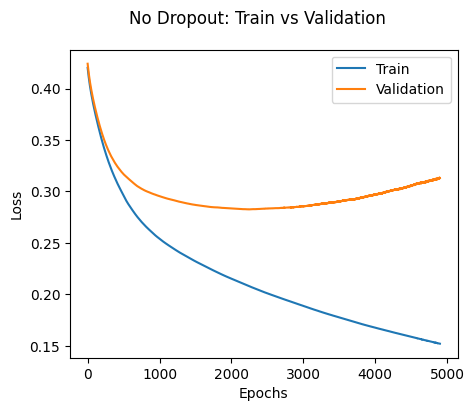

In [8]:
plot_result(loss_history, start_epoch=100, title="No Dropout: Train vs Validation")

##### With Dropout

In Pytorch `nn.Dropout`, `p` is the probability of **Dropping**.

In [9]:
class NN_Dropout(torch.nn.Module):

  def __init__(self, Input_Size=8):
    super(NN_Dropout, self).__init__()
    self.H1 = torch.nn.Sequential(
        torch.nn.Linear(Input_Size, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.4) # <-- (40% drop)
        )
    self.H2 = torch.nn.Sequential(
        torch.nn.Linear(128, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2) # <-- (20% drop)
        )
    self.H3 = torch.nn.Sequential(
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1) # <-- (10% drop)
        )
    self.Output = torch.nn.Linear(64, 1)

  def forward(self, Input):
    Output = self.H1(Input)
    Output = self.H2(Output)
    Output = self.H3(Output)
    Output = self.Output(Output)
    return Output

nn_dropout = NN_Dropout()
loss_history = simple_training(train_dl, test_dl, nn_dropout, n_epochs=5000)

Epochs 500   train loss 0.488668 valid loss 0.420560
Epochs 1000  train loss 0.421871 valid loss 0.379992
Epochs 1500  train loss 0.381907 valid loss 0.353083
Epochs 2000  train loss 0.362477 valid loss 0.339743
Epochs 2500  train loss 0.342592 valid loss 0.326320
Epochs 3000  train loss 0.327129 valid loss 0.315405
Epochs 3500  train loss 0.321042 valid loss 0.309632
Epochs 4000  train loss 0.317195 valid loss 0.307338
Epochs 4500  train loss 0.310837 valid loss 0.301206
Epochs 5000  train loss 0.299037 valid loss 0.301227


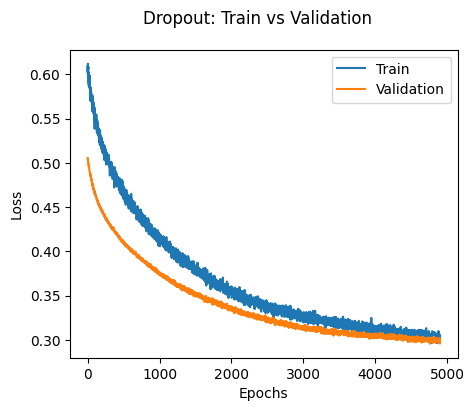

In [10]:
plot_result(loss_history, start_epoch=100, title="Dropout: Train vs Validation")

### L1-Lasso and L2-Ridge Regularization

----
#### The simply only convex + regularizer (Example: longtitude-latitude attributes of Cal. housing)

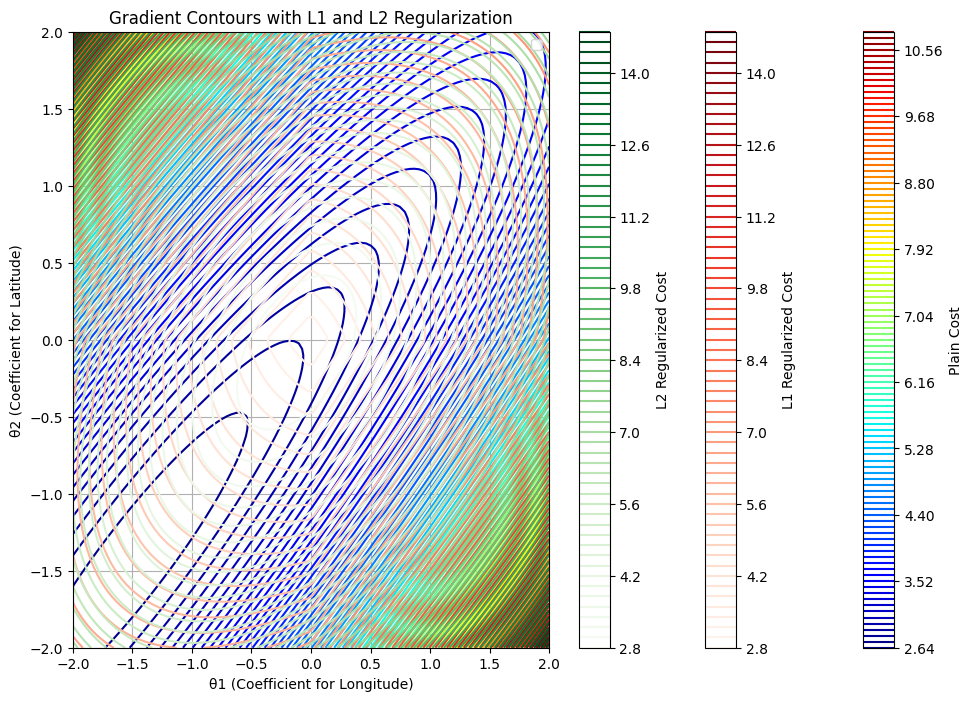

In [11]:
# Load California Housing dataset
california_housing = fetch_california_housing()
X = california_housing.data[:, [6, 7]]  # Longtitude-Latitude
y = california_housing.target

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cost functions with L1 and L2 regularization
def compute_cost(theta, X, y):
    m = len(y)
    predictions = X @ theta
    return np.sum((predictions - y) ** 2) / (2 * m)

def compute_cost_L1(theta, X, y, lambda_):
    return compute_cost(theta, X, y) + lambda_ * np.sum(np.abs(theta))

def compute_cost_L2(theta, X, y, lambda_):
    return compute_cost(theta, X, y) + (lambda_ / 2) * np.sum(theta ** 2)

# Parameters for plotting
theta_vals = np.linspace(-2, 2, 100)
theta_1_grid, theta_2_grid = np.meshgrid(theta_vals, theta_vals)
cost_grid_plain = np.zeros_like(theta_1_grid)
cost_grid_L1 = np.zeros_like(theta_1_grid)
cost_grid_L2 = np.zeros_like(theta_1_grid)

lambda_ = 1.0  # Regularization strength

# Calculate cost for every point
for i in range(len(theta_vals)):
    for j in range(len(theta_vals)):
        theta = np.array([theta_1_grid[i, j], theta_2_grid[i, j]])
        cost_grid_plain[i, j] = compute_cost(theta, X_train, y_train)
        cost_grid_L1[i, j] = compute_cost_L1(theta, X_train, y_train, lambda_)
        cost_grid_L2[i, j] = compute_cost_L2(theta, X_train, y_train, lambda_)

# Plot contours
plt.figure(figsize=(12, 8))

# Plot the original cost function (no regularization)
contour_plain = plt.contour(theta_1_grid, theta_2_grid, cost_grid_plain, levels=128, cmap="jet", alpha=1.0)
plt.colorbar(contour_plain, label="Plain Cost")

# Plot L1-regularized contours
contour_L1 = plt.contour(theta_1_grid, theta_2_grid, cost_grid_L1, levels=64, cmap="Reds", alpha=1.0)
plt.colorbar(contour_L1, label="L1 Regularized Cost")

# Plot L2-regularized contours
contour_L2 = plt.contour(theta_1_grid, theta_2_grid, cost_grid_L2, levels=64, cmap="Greens", alpha=1.0)
plt.colorbar(contour_L2, label="L2 Regularized Cost")

# Add labels and title
plt.title("Gradient Contours with L1 and L2 Regularization")
plt.xlabel("θ1 (Coefficient for Longitude)")
plt.ylabel("θ2 (Coefficient for Latitude)")

# Legend
plt.legend(["Plain Cost", "L1-Regularized", "L2-Regularized"])
plt.grid()
plt.show()


##### GD and SGD + regularizer implementation

In [12]:
# Gradient Descent Implementation
def simple_gradient_descent(X, y, initial_theta, learning_rate, epochs, compute_cost_func, lambda_=0):
    theta = initial_theta
    theta_history = [theta.copy()]
    m = len(y)
    for _ in range(epochs):
        predictions = X @ theta
        gradients = (X.T @ (predictions - y)) / m  # Gradient of plain cost
        # Add regularization terms to gradients
        if compute_cost_func == compute_cost_L1:
            gradients += lambda_ * np.sign(theta)  # L1 regularization gradient
        elif compute_cost_func == compute_cost_L2:
            gradients += lambda_ * theta           # L2 regularization gradient
        # Update parameters
        theta -= learning_rate * gradients
        theta_history.append(theta.copy())
    return theta, theta_history

# Stochastic Gradient Descent Implementation
def stochastic_gradient_descent(X, y, initial_theta, learning_rate, epochs, compute_cost_func, lambda_=0):
    theta = initial_theta.copy()  # Ensure theta is not modified in place
    theta_history = [theta.copy()]
    m, n = X.shape  # m = number of samples, n = number of features
    for _ in range(epochs):
        for i in range(m):
            random_idx = np.random.randint(m)  # Random sample index
            xi = X[random_idx:random_idx+1]    # Select one sample (reshape for matrix multiplication)
            yi = y[random_idx:random_idx+1]    # Select corresponding target
            # Compute gradient
            predictions = xi @ theta
            gradients = xi.T * (predictions - yi)  # Shape: (n_features, 1)
            gradients = gradients.flatten()       # Flatten to (n_features,) for easier manipulation
            # Add regularization terms to gradients
            if compute_cost_func == compute_cost_L1:
                gradients += lambda_ * np.sign(theta)  # L1 regularization gradient
            elif compute_cost_func == compute_cost_L2:
                gradients += lambda_ * theta           # L2 regularization gradient
            # Update parameters
            theta -= learning_rate * gradients
            theta_history.append(theta.copy())
    return theta, theta_history

##### Gradient descent paths

L1-Lasso SGD + Plain SGD

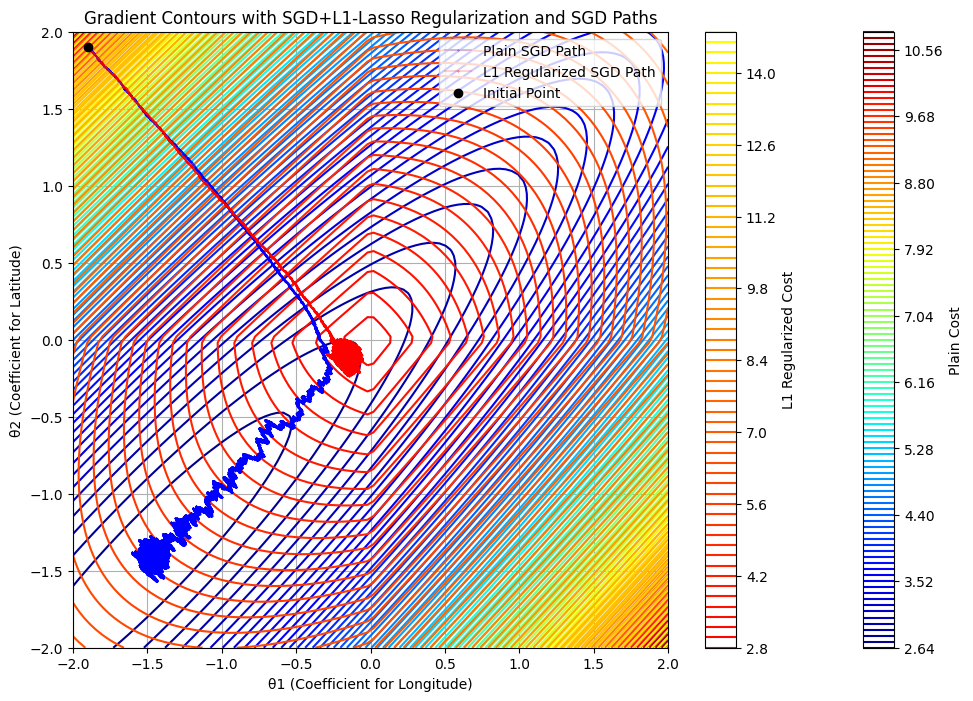

In [13]:
# Initialize parameters
initial_theta = np.array([-1.9, 1.9])  # Starting point in parameter space
learning_rate = 5e-4
epochs = 50

# Compute gradient descent paths
theta_plain, history_plain = stochastic_gradient_descent(X_train, y_train, initial_theta, learning_rate, epochs, compute_cost)
theta_L1, history_L1 = stochastic_gradient_descent(X_train, y_train, initial_theta, learning_rate, epochs, compute_cost_L1, lambda_=0.1)

# Convert histories to arrays for plotting
history_plain = np.array(history_plain)
history_L1 = np.array(history_L1)

# Plot contours and gradient paths
plt.figure(figsize=(12, 8))

# Contours for cost functions
contour_plain = plt.contour(theta_1_grid, theta_2_grid, cost_grid_plain, levels=128, cmap="jet", alpha=1.0)
plt.colorbar(contour_plain, label="Plain Cost")
contour_L1 = plt.contour(theta_1_grid, theta_2_grid, cost_grid_L1, levels=64, cmap="autumn", alpha=1.0)
plt.colorbar(contour_L1, label="L1 Regularized Cost")
# contour_L2 = plt.contour(theta_1_grid, theta_2_grid, cost_grid_L2, levels=15, cmap="Greens", alpha=0.6)
# plt.colorbar(contour_L2, label="L2 Regularized Cost")

# Plot gradient descent paths
plt.plot(history_plain[:, 0], history_plain[:, 1], 'o-', linewidth=0.25, color='blue', markersize=0.25, label="Plain SGD Path")
plt.plot(history_L1[:, 0], history_L1[:, 1], 'o-', linewidth=0.25, color='red', markersize=0.25, label="L1 Regularized SGD Path")
# plt.plot(history_L2[:, 0], history_L2[:, 1], 'o-', color='green', markersize=4, label="L2 Regularized GD Path")

# Highlight initial point
plt.scatter(initial_theta[0], initial_theta[1], color='black', label="Initial Point", zorder=5)

# Add labels, legend, and title
plt.title("Gradient Contours with SGD+L1-Lasso Regularization and SGD Paths")
plt.xlabel("θ1 (Coefficient for Longitude)")
plt.ylabel("θ2 (Coefficient for Latitude)")
plt.legend()
plt.grid()
plt.show()


L2 Ridge

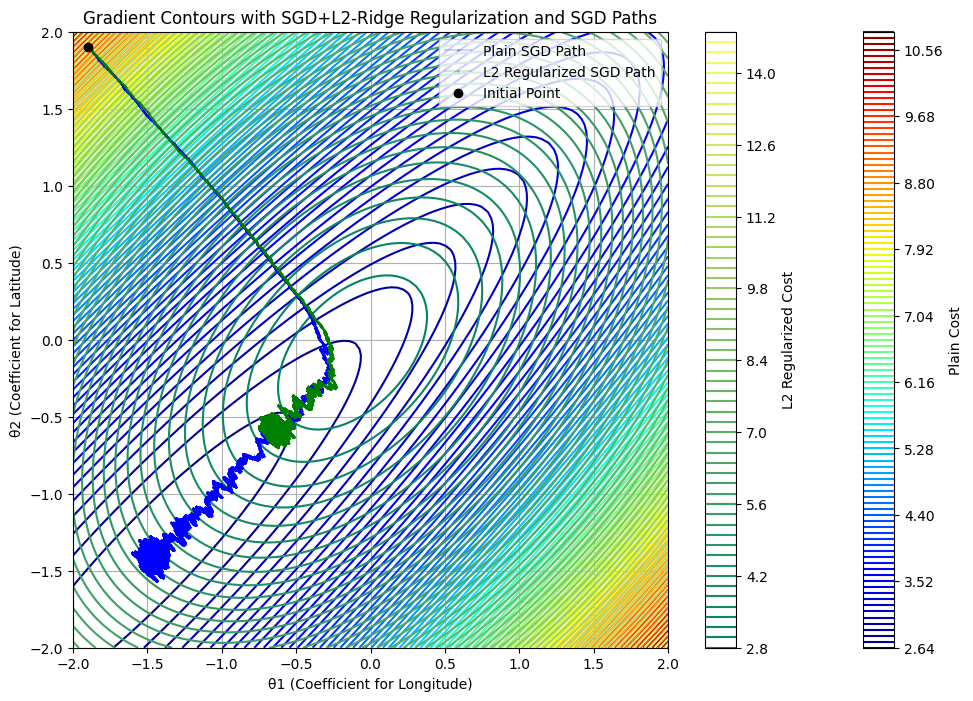

In [14]:
# Compute gradient descent paths
theta_L2, history_L2 = stochastic_gradient_descent(X_train, y_train, initial_theta, learning_rate, epochs, compute_cost_L2, lambda_=0.1)

# Convert histories to arrays for plotting
history_L2 = np.array(history_L2)

# Plot contours and gradient paths
plt.figure(figsize=(12, 8))

# Contours for cost functions
contour_plain = plt.contour(theta_1_grid, theta_2_grid, cost_grid_plain, levels=128, cmap="jet", alpha=1.0)
plt.colorbar(contour_plain, label="Plain Cost")
contour_L2 = plt.contour(theta_1_grid, theta_2_grid, cost_grid_L2, levels=64, cmap="summer", alpha=1.0)
plt.colorbar(contour_L2, label="L2 Regularized Cost")

# Plot gradient descent paths
plt.plot(history_plain[:, 0], history_plain[:, 1], 'o-', linewidth=0.25, color='blue', markersize=0.25, label="Plain SGD Path")
plt.plot(history_L2[:, 0], history_L2[:, 1], 'o-', linewidth=0.25, color='green', markersize=0.25, label="L2 Regularized SGD Path")

# Highlight initial point
plt.scatter(initial_theta[0], initial_theta[1], color='black', label="Initial Point", zorder=5)

# Add labels, legend, and title
plt.title("Gradient Contours with SGD+L2-Ridge Regularization and SGD Paths")
plt.xlabel("θ1 (Coefficient for Longitude)")
plt.ylabel("θ2 (Coefficient for Latitude)")
plt.legend()
plt.grid()
plt.show()

----
#### Multiple-convex (Plateau) and an only global minimum

##### SGD + regularizer implementation

In [15]:
# Custom cost functions without and with L1 and L2 regularization
def custom_cost_function(theta):
    theta_1, theta_2 = theta
    cost = np.sin(theta_1) * np.cos(theta_2) + 0.1 * (theta_1**2 + theta_2**2)
    return cost

def custom_cost_function_L1(theta, lambda_=0.1):
    theta_1, theta_2 = theta
    cost = np.sin(theta_1) * np.cos(theta_2) + 0.1 * (theta_1**2 + theta_2**2) + lambda_ * (np.abs(theta_1) + np.abs(theta_2))
    return cost

def custom_cost_function_L2(theta, lambda_=0.1):
    theta_1, theta_2 = theta
    cost = np.sin(theta_1) * np.cos(theta_2) + 0.1 * (theta_1**2 + theta_2**2) + lambda_ * (theta_1**2 + theta_2**2)
    return cost

# Gradients of the custom cost functions
def custom_gradients(theta):
    theta_1, theta_2 = theta
    grad_theta_1 = np.cos(theta_1) * np.cos(theta_2) + 0.2 * theta_1
    grad_theta_2 = -np.sin(theta_1) * np.sin(theta_2) + 0.2 * theta_2
    return np.array([grad_theta_1, grad_theta_2])

def custom_gradients_L1(theta, lambda_=0.1):
    theta_1, theta_2 = theta
    grad_theta_1 = np.cos(theta_1) * np.cos(theta_2) + 0.2 * theta_1 + lambda_ * np.sign(theta_1)   # grad of loss + grad of reg
    grad_theta_2 = -np.sin(theta_1) * np.sin(theta_2) + 0.2 * theta_2 + lambda_ * np.sign(theta_2)
    return np.array([grad_theta_1, grad_theta_2])

def custom_gradients_L2(theta, lambda_=0.1):
    theta_1, theta_2 = theta
    grad_theta_1 = np.cos(theta_1) * np.cos(theta_2) + 0.2 * theta_1 + 2 * lambda_ * theta_1
    grad_theta_2 = -np.sin(theta_1) * np.sin(theta_2) + 0.2 * theta_2 + 2 * lambda_ * theta_2
    return np.array([grad_theta_1, grad_theta_2])

# Stochastic Gradient Descent
def stochastic_gradient_descent_regularized(initial_theta, learning_rate, epochs, gradients_func, lambda_, reg = 'L1'):
    theta = np.array(initial_theta)
    theta_history = [theta.copy()]

    for epoch in range(epochs):
        if reg in {'L1', 'L2'}:
          gradients = gradients_func(theta, lambda_)
        else:
          gradients = gradients_func(theta)
        theta -= learning_rate * gradients
        theta_history.append(theta.copy())

    return theta, theta_history

##### Gradient descent paths of SGD

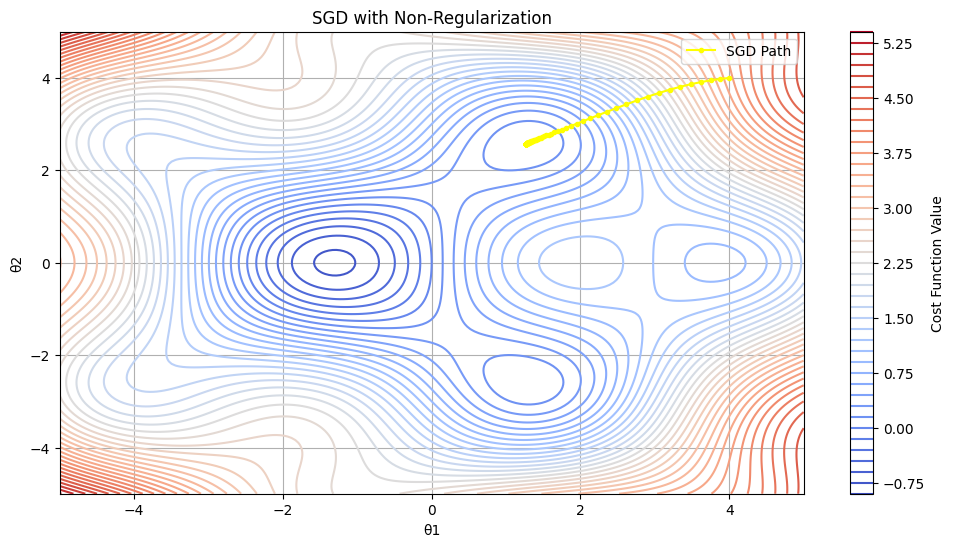

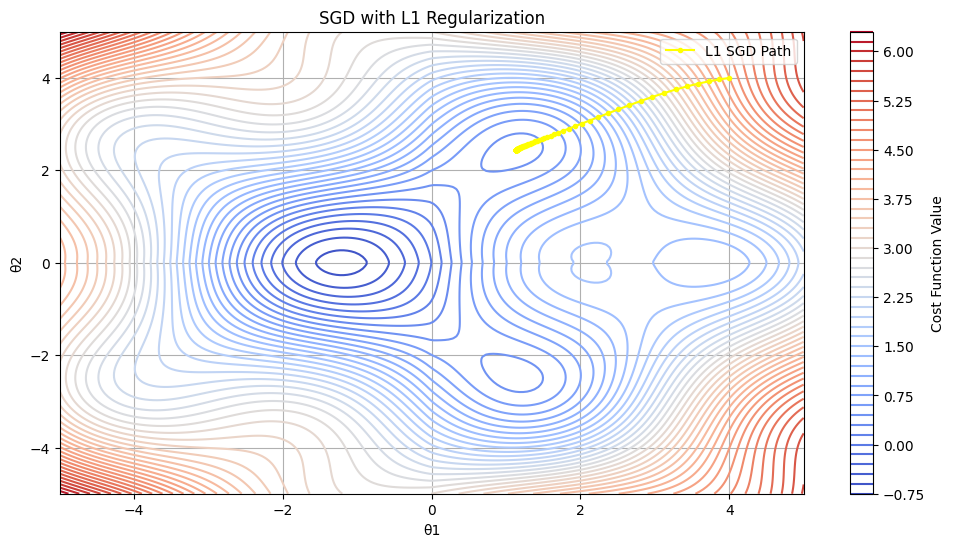

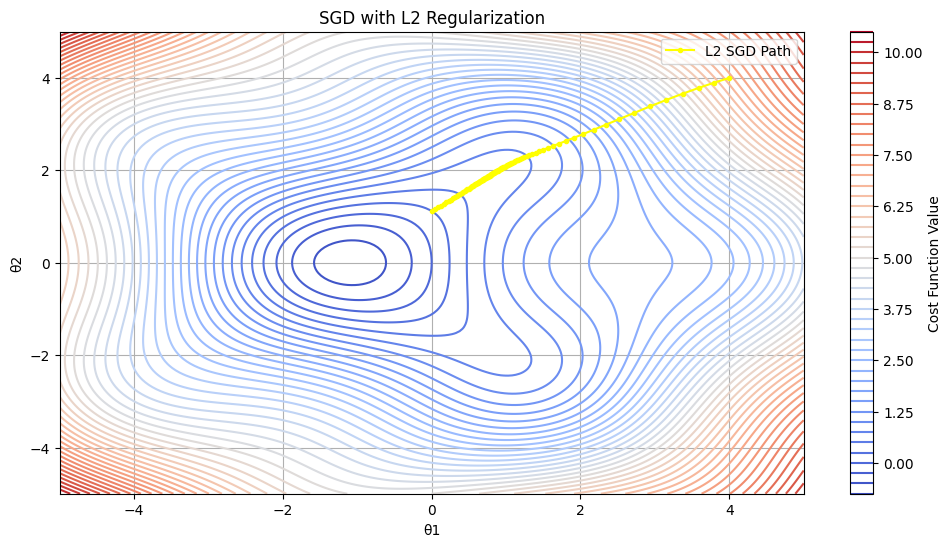

In [16]:
# Initialize parameters
initial_theta = [4.0, 4.0]
learning_rate = 0.1
epochs = 100
lambda_ = 0.1  # Regularization strength

# Perform SGD with L1 and L2 regularization
_, theta_history = stochastic_gradient_descent_regularized(initial_theta, learning_rate, epochs, custom_gradients, lambda_=0., reg=None)
_, theta_history_L1 = stochastic_gradient_descent_regularized(initial_theta, learning_rate, epochs, custom_gradients_L1, lambda_, reg='L1')
_, theta_history_L2 = stochastic_gradient_descent_regularized(initial_theta, learning_rate, epochs, custom_gradients_L2, lambda_, reg='L2')

# Generate grid for plotting the custom cost functions
theta_1_vals = np.linspace(-5, 5, 200)
theta_2_vals = np.linspace(-5, 5, 200)
theta_1_grid, theta_2_grid = np.meshgrid(theta_1_vals, theta_2_vals)

# Compute cost grids
cost_grid = np.array([[custom_cost_function((t1, t2)) for t1, t2 in zip(row1, row2)]
                         for row1, row2 in zip(theta_1_grid, theta_2_grid)])
cost_grid_L1 = np.array([[custom_cost_function_L1((t1, t2), lambda_) for t1, t2 in zip(row1, row2)]
                         for row1, row2 in zip(theta_1_grid, theta_2_grid)])
cost_grid_L2 = np.array([[custom_cost_function_L2((t1, t2), lambda_) for t1, t2 in zip(row1, row2)]
                         for row1, row2 in zip(theta_1_grid, theta_2_grid)])

# Plot contours for non-regularization
plt.figure(figsize=(12, 6))
plt.contour(theta_1_grid, theta_2_grid, cost_grid, levels=50, cmap='coolwarm')
plt.plot(np.array(theta_history)[:, 0], np.array(theta_history)[:, 1], 'o-', color='yellow', label='SGD Path', markersize=3)
plt.title('SGD with Non-Regularization')
plt.xlabel('θ1')
plt.ylabel('θ2')
plt.colorbar(label='Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot contours for L1 regularization
plt.figure(figsize=(12, 6))
plt.contour(theta_1_grid, theta_2_grid, cost_grid_L1, levels=50, cmap='coolwarm')
plt.plot(np.array(theta_history_L1)[:, 0], np.array(theta_history_L1)[:, 1], 'o-', color='yellow', label='L1 SGD Path', markersize=3)
plt.title('SGD with L1 Regularization')
plt.xlabel('θ1')
plt.ylabel('θ2')
plt.colorbar(label='Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot contours for L2 regularization
plt.figure(figsize=(12, 6))
plt.contour(theta_1_grid, theta_2_grid, cost_grid_L2, levels=50, cmap='coolwarm')
plt.plot(np.array(theta_history_L2)[:, 0], np.array(theta_history_L2)[:, 1], 'o-', color='yellow', label='L2 SGD Path', markersize=3)
plt.title('SGD with L2 Regularization')
plt.xlabel('θ1')
plt.ylabel('θ2')
plt.colorbar(label='Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()


----
#### In Pytorch

##### Dataset and neural network model

In [17]:
def california_housing_dataloader():
    california_housing = fetch_california_housing()
    print(california_housing.feature_names)
    inputs = california_housing.data
    labels = california_housing.target

    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.from_numpy(X_train).to(torch.float32)
    X_test = torch.from_numpy(X_test).to(torch.float32)
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=128)
    test_dataloader = DataLoader(test_dataset, batch_size=128)

    return train_dataloader, test_dataloader

def show_r2_score(y, y_pred):
    y, y_pred = y.numpy(), y_pred.numpy()
    total = np.sum((y - np.mean(y)) ** 2)
    residual = np.sum((y - y_pred) ** 2)
    r2 = 1 - (residual / total)
    print("R2 score:", r2)

class Simple_NN(torch.nn.Module):
    def __init__(self, Input_Size=8):
      super(Simple_NN, self).__init__()
      self.HiddenLayers = torch.nn.Sequential(
          torch.nn.Linear(Input_Size, 64),
          torch.nn.ReLU(),
          )
      self.Output = torch.nn.Linear(64, 1)

    def forward(self, Input):
      Output = self.HiddenLayers(Input)
      Output = self.Output(Output)
      return Output

In [18]:
train_dl, test_dl = california_housing_dataloader()

test_X, test_y = next(iter(test_dl))

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


##### No Regularization

In [19]:
def No_Reg_training(train_dl, test_dl, model, n_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    n_show_loss = n_epochs // 5 if n_epochs > 5 else 1
    loss_history = {"train":[]}

    # Begin training loop
    for epoch in range(n_epochs):
        train_loss = 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            loss = loss_fn(y_pred.squeeze(), y_t.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        loss_history["train"].append(train_loss / len(train_dl))

        if epoch < 10:
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")
        elif ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")

    return loss_history

no_reg_model = Simple_NN()
loss_history = No_Reg_training(train_dl, test_dl, no_reg_model, n_epochs=1000)
show_r2_score(test_y, no_reg_model(test_X).cpu().detach())

Epochs 1     train loss 3.218971
Epochs 2     train loss 1.362083
Epochs 3     train loss 0.946169
Epochs 4     train loss 0.758772
Epochs 5     train loss 0.674834
Epochs 6     train loss 0.636704
Epochs 7     train loss 0.617066
Epochs 8     train loss 0.604670
Epochs 9     train loss 0.595254
Epochs 10    train loss 0.587253
Epochs 200   train loss 0.409256
Epochs 400   train loss 0.371222
Epochs 600   train loss 0.349654
Epochs 800   train loss 0.334650
Epochs 1000  train loss 0.323094
R2 score: -219.97392


##### L1 Lasso Regularization

In [20]:
# Function to compute L1 loss of weights
def compute_L1_loss(model, lambda_=1.0):
    L1 = 0.0
    for param in model.parameters():
        L1 += torch.abs(param).sum()
    L1 = lambda_ * L1
    return L1

# This way to compute also works
def compute_L1_loss_alt(model, lambda_=1.0):
    l1_crit = torch.nn.L1Loss(reduction='sum') # MAE function
    L1 = 0.0
    for param in model.parameters():
        L1 += l1_crit(param, target=torch.zeros_like(param))
    L1 = lambda_ * L1
    return L1

def L1_training(train_dl, test_dl, model, L1_lambda=1.0, n_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    n_show_loss = n_epochs // 5 if n_epochs > 5 else 1
    loss_history = {"train":[]}

    # Begin training loop
    for epoch in range(n_epochs):
        train_loss = 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            loss = loss_fn(y_pred.squeeze(), y_t.squeeze())

            # Compute L1 loss
            L1 = compute_L1_loss(model, lambda_=L1_lambda)
            # L1 = compute_L1_loss_alt(model, lambda_=L1_lambda) # This also works

            # Add L1 loss
            loss += L1

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        loss_history["train"].append(train_loss / len(train_dl))

        if epoch < 10:
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")
        elif ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")

    return loss_history

L1_model = Simple_NN()
loss_history = L1_training(train_dl, test_dl, L1_model, L1_lambda=1.0, n_epochs=1000)
show_r2_score(test_y, L1_model(test_X).cpu().detach())

Epochs 1     train loss 70.830424
Epochs 2     train loss 20.961473
Epochs 3     train loss 4.619832
Epochs 4     train loss 3.835910
Epochs 5     train loss 3.674013
Epochs 6     train loss 3.583795
Epochs 7     train loss 3.533514
Epochs 8     train loss 3.505501
Epochs 9     train loss 3.489885
Epochs 10    train loss 3.481192
Epochs 200   train loss 3.470252
Epochs 400   train loss 3.470244
Epochs 600   train loss 3.470264
Epochs 800   train loss 3.470271
Epochs 1000  train loss 3.470254
R2 score: -147.04158


##### L2 Ridge Regularization

In [21]:
# Function to compute L2 loss of weights
def compute_L2_loss(model, lambda_=0.5):
    L2 = 0.0
    for param in model.parameters():
        L2 += torch.square(param).sum()
    L2 = lambda_ * L2
    return L2

def L2_training(train_dl, test_dl, model, L2_lambda=1.0, n_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    n_show_loss = n_epochs // 5 if n_epochs > 5 else 1
    loss_history = {"train":[]}

    # Begin training loop
    for epoch in range(n_epochs):
        train_loss = 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            loss = loss_fn(y_pred.squeeze(), y_t.squeeze())

            # Compute L2 loss
            L2 = compute_L2_loss(model, lambda_=L2_lambda)

            # Add L2 loss
            loss += L2

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        loss_history["train"].append(train_loss / len(train_dl))

        if epoch < 10:
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")
        elif ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}")

    return loss_history

L2_model = Simple_NN()
loss_history = L2_training(train_dl, test_dl, L2_model, L2_lambda=1.0, n_epochs=1000)
show_r2_score(test_y, L2_model(test_X).cpu().detach())

Epochs 1     train loss 22.756175
Epochs 2     train loss 13.673662
Epochs 3     train loss 9.062903
Epochs 4     train loss 6.545843
Epochs 5     train loss 5.153917
Epochs 6     train loss 4.375268
Epochs 7     train loss 3.933592
Epochs 8     train loss 3.679564
Epochs 9     train loss 3.531466
Epochs 10    train loss 3.443986
Epochs 200   train loss 3.310448
Epochs 400   train loss 3.310448
Epochs 600   train loss 3.310448
Epochs 800   train loss 3.310448
Epochs 1000  train loss 3.310448
R2 score: -201.20859


L2 based weight decay can also be implemented by setting a lambda value for `weight_decay` in the optimizer.

```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1.0)
```

This option works a bit differently from adding L2 to loss as the weight decay is applied to the gradient itself.

### Batchnorm

----
#### In Practice (From Scratch)

In [22]:
def batchnorm_forward(X, gamma, beta, moving_mean, moving_var, training=True, epsilon=1e-5, momentum=0.1):
    # epsilon: Small constant for numerical stability.
    # momentum: The value used to govern the aggregation over past mean and variance estimates.

    if not training:
        # In inference mode, use mean and variance obtained by moving average
        X_norm = (X - moving_mean) / np.sqrt(moving_var + epsilon)
    else:
        # In training mode
        # Calculate mean of each X feature in mini-batch
        mean = np.mean(X, axis=0)
        print(mean.shape)

        # Calculate variance of each X feature in mini-batch
        var = np.mean((X - mean) ** 2, axis=0)

        # Normalization calculation
        X_norm = (X - mean) / np.sqrt(var + epsilon)

        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var

    # Scaling and shifting calculation
    output = gamma * X_norm + beta

    # Store values for inference and backward pass
    cache = (X, moving_mean, moving_var, gamma, beta, epsilon)

    return output, cache


def batchnorm_backward(dout, cache):
    x, mean, var, gamma, beta, epsilon = cache
    n_batch, n_feat = dout.shape

    # Calculate Derivatives with respect to gamma and beta
    dgamma = np.sum(dout * (x - mean) / np.sqrt(var + epsilon), axis=0)
    dbeta = np.sum(dout, axis=0)

    # Calculate Derivatives with respect to x_norm
    dx_norm = dout * gamma

    # 2. Calculate Derivatives with respect to x
    # np.sum((0.5) * (1. / np.sqrt(var + epsilon)) * (-1. /(np.sqrt(var + epsilon)**2)) * dx_norm * (x - mean), axis=0)
    dvar = np.sum((-0.5) * (var + epsilon)**(-1.5) * dx_norm * (x - mean), axis=0)
    dmean_1 = dx_norm * (1. / np.sqrt(var + epsilon))
    dmean_2 = 2 * (x - mean) * (1. /n_batch * np.ones((n_batch, n_feat)) * dvar)
    dmean = -1 * np.sum(dmean_1 + dmean_2, axis=0)
    dx = (dmean_1 + dmean_2) + (1. /n_batch * np.ones((n_batch, n_feat)) * dmean)

    return dx, dgamma, dbeta


# Batch of 5 samples with 3 features
# Which is the input or the activations from previous hiddden layer
X = np.random.randn(5, 3)
# Scale parameter of same size as features (default=1)
gamma = np.ones(3)
# Shift parameter of same size as features (default=0)
beta = np.zeros(3)
# Moving average for mean and variance during inference mode
moving_mean = np.zeros(3)
moving_var = np.ones(3)

train_state=True

print("Input:\n", X)

# Forward
out, cache = batchnorm_forward(X, gamma, beta, moving_mean, moving_var, training=train_state)
print("Output:\n", out)

# Backward
if train_state:
    dout = np.random.randn(5, 3)
    dx, dgamma, dbeta = batchnorm_backward(dout, cache)
    print("\nDerivatives with respect to x:\n", dx)
    print("\nDerivatives with respect to gamma:\n", dgamma)
    print("\nDerivatives with respect to beta:\n", dbeta)

Input:
 [[-1.01637994  1.31875746  0.4916791 ]
 [-0.32529392  0.09928763 -0.90302473]
 [ 1.58334753 -1.8452145  -1.19015531]
 [ 0.87005135 -1.89976552 -1.68894025]
 [ 1.35646047 -1.93871737 -0.88059843]]
(3,)
Output:
 [[-1.50633551  1.6295088   1.83088161]
 [-0.81693441  0.71457355 -0.09502726]
 [ 1.08705364 -0.74433384 -0.49151814]
 [ 0.37549653 -0.785262   -1.1802768 ]
 [ 0.86071975 -0.81448652 -0.0640594 ]]

Derivatives with respect to x:
 [[-1.36148561 -0.17833996 -0.96616682]
 [ 1.15184689 -0.59740342  0.57958056]
 [ 0.52101085  0.30242638 -1.35802834]
 [-0.89710498 -0.26759654  0.68431498]
 [ 0.58573285  0.74091354  1.06029963]]

Derivatives with respect to gamma:
 [-1.51966727  1.03035183  3.8385197 ]

Derivatives with respect to beta:
 [-4.14571897 -1.50405698 -4.15524861]


----
#### In Pytorch

##### Dataset and training function

In [23]:
def california_housing_dataloader():
    california_housing = fetch_california_housing()
    print(california_housing.feature_names)
    inputs = california_housing.data
    labels = california_housing.target

    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.from_numpy(X_train).to(torch.float32)
    X_test = torch.from_numpy(X_test).to(torch.float32)
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=128)
    test_dataloader = DataLoader(test_dataset, batch_size=128)

    return train_dataloader, test_dataloader

def simple_training(train_dl, test_dl, model, n_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    loss_history = {"train":[], "validate":[]}

    # Begin training loop
    for epoch in range(n_epochs):
        train_loss = 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            loss = loss_fn(y_pred.squeeze(), y_t.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        loss_history["train"].append(train_loss / len(train_dl))

        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())
                valid_loss += vloss.item()
        loss_history["validate"].append(valid_loss / len(test_dl))

        if ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {loss_history['train'][-1]:.6f}",
                  f"valid loss {loss_history['validate'][-1]:.6f}")

    return loss_history

In [24]:
train_dl, test_dl = california_housing_dataloader()

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


##### Without BatchNorm

In [25]:
class WithoutBatchNorm_NN(torch.nn.Module):
    def __init__(self, Input_Size=8):
      super(WithoutBatchNorm_NN, self).__init__()
      self.HiddenLayers = torch.nn.Sequential(
          torch.nn.Linear(Input_Size, 128),
          torch.nn.ReLU(),
          torch.nn.Linear(128, 64),
          torch.nn.ReLU()
          )
      self.Output = torch.nn.Linear(64, 1)

    def forward(self, Input):
      Output = self.HiddenLayers(Input)
      Output = self.Output(Output)
      return Output

wo_bn_nn = WithoutBatchNorm_NN()
loss_history = simple_training(train_dl, test_dl, wo_bn_nn, n_epochs=100)

Epochs 10    train loss 0.618265 valid loss 0.617822
Epochs 20    train loss 0.529359 valid loss 0.534205
Epochs 30    train loss 0.483468 valid loss 0.491459
Epochs 40    train loss 0.458097 valid loss 0.467993
Epochs 50    train loss 0.442599 valid loss 0.452874
Epochs 60    train loss 0.431449 valid loss 0.441414
Epochs 70    train loss 0.422342 valid loss 0.431602
Epochs 80    train loss 0.414400 valid loss 0.423011
Epochs 90    train loss 0.407219 valid loss 0.415526
Epochs 100   train loss 0.400854 valid loss 0.408588


##### With BatchNorm

In [26]:
class BatchNorm_NN(torch.nn.Module):
    def __init__(self, Input_Size=8):
      super(BatchNorm_NN, self).__init__()
      self.HiddenLayers = torch.nn.Sequential(
          torch.nn.Linear(Input_Size, 128),
          torch.nn.ReLU(),
          torch.nn.BatchNorm1d(128), # <-- 1d = 1 dimension data
          torch.nn.Linear(128, 64),
          torch.nn.ReLU(),
          torch.nn.BatchNorm1d(64) # <--
          )
      self.Output = torch.nn.Linear(64, 1)

    def forward(self, Input):
      Output = self.HiddenLayers(Input)
      Output = self.Output(Output)
      return Output

bn_nn = BatchNorm_NN()
loss_history = simple_training(train_dl, test_dl, bn_nn, n_epochs=100) # lower loss with less epochs

Epochs 10    train loss 0.398054 valid loss 0.413765
Epochs 20    train loss 0.359169 valid loss 0.385873
Epochs 30    train loss 0.339411 valid loss 0.372944
Epochs 40    train loss 0.324881 valid loss 0.363846
Epochs 50    train loss 0.314040 valid loss 0.358450
Epochs 60    train loss 0.305359 valid loss 0.353695
Epochs 70    train loss 0.298334 valid loss 0.348442
Epochs 80    train loss 0.292117 valid loss 0.343483
Epochs 90    train loss 0.286853 valid loss 0.338676
Epochs 100   train loss 0.282344 valid loss 0.336232


### Data Augmentation

#### Torchvision

In [27]:
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

##### Example Image

In [28]:
# Getting high resolution example image
!wget -O astronaut.jpg https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/astronaut.jpg

import PIL.Image as Image
import os
img = Image.open(os.getcwd()+"/astronaut.jpg")

--2025-08-20 16:55:30--  https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/astronaut.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40344 (39K) [image/jpeg]
Saving to: ‘astronaut.jpg’

astronaut.jpg       100%[===================>]  39.40K  --.-KB/s    in 0.01s   

2025-08-20 16:55:30 (3.26 MB/s) - ‘astronaut.jpg’ saved [40344/40344]



##### Image to Tensor data

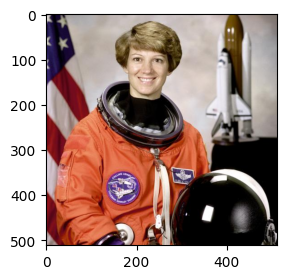

In [29]:
# Original with transform to tensor data type
img = v2.ToImage()(img)
img = v2.ToDtype(torch.float32, scale=True)(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

##### Geometric Transforms

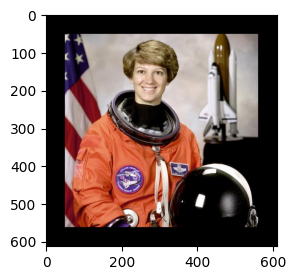

In [30]:
# Pad - pads all image borders with some pixel values
transform = v2.Pad(padding=50)
padded_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(padded_img.numpy(), (1, 2, 0)))
plt.show()

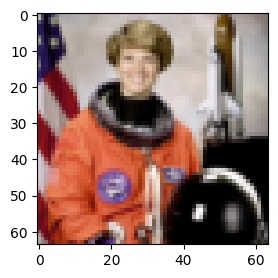

In [31]:
# Resize - resizes an image
transform = v2.Resize(size=64)
resize_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(resize_img.numpy(), (1, 2, 0)))
plt.show()

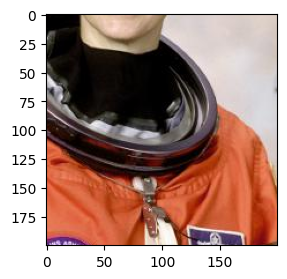

In [32]:
# CenterCrop - crops the given image at the center
transform = v2.CenterCrop(size=200)
center_crop_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(center_crop_img.numpy(), (1, 2, 0)))
plt.show()

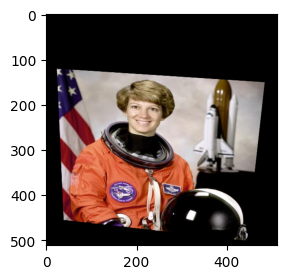

In [33]:
# RandomPerspective - performs random perspective transform on an image
transform = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(perspective_img.numpy(), (1, 2, 0)))
plt.show()

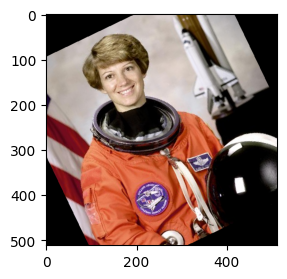

In [34]:
# RandomRotation - rotates an image with random angle
transform = v2.RandomRotation(degrees=(0, 180))
rotated_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(rotated_img.numpy(), (1, 2, 0)))
plt.show()

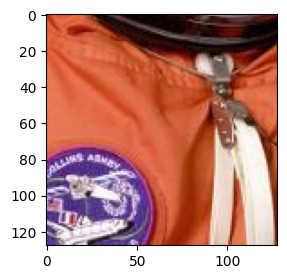

In [35]:
# RandomCrop - crops an image at a random location
transform = v2.RandomCrop(size=(128, 128))
crops_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(crops_img.numpy(), (1, 2, 0)))
plt.show()

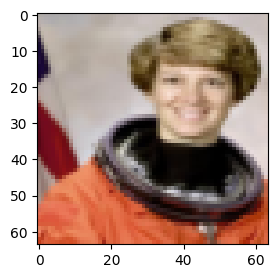

In [36]:
# RandomResizedCrop - crops an image at a random location, and then resizes the crop to a given size
transform = v2.RandomResizedCrop(size=(64, 64))
rr_crops_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(rr_crops_img.numpy(), (1, 2, 0)))
plt.show()

##### Photometric Transforms

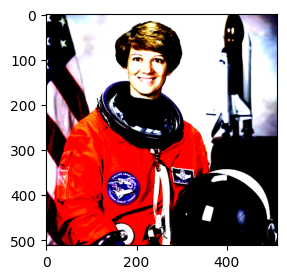

In [37]:
# Normalize - normalize a tensor image or video with mean and standard deviation
transform = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(norm_img.clamp(0, 1).numpy(), (1, 2, 0)))
plt.show()

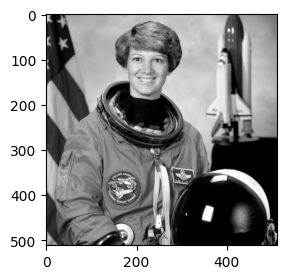

In [38]:
# Grayscale - converts an image to grayscale
transform = v2.Grayscale()
grey_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(grey_img.numpy(), (1, 2, 0)), cmap='gray')
plt.show()

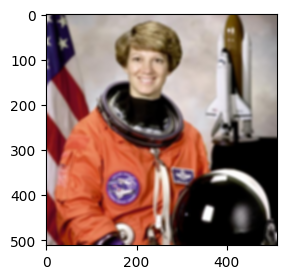

In [39]:
# GaussianBlur - performs gaussian blur transform on an image
transform = v2.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 5.))
blur_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(blur_img.numpy(), (1, 2, 0)))
plt.show()

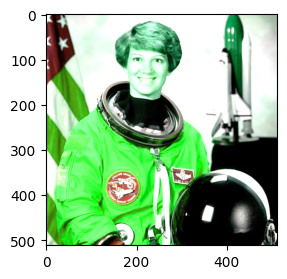

In [40]:
# ColorJitter - transform randomly changes the brightness, contrast, saturation, hue, and other properties of an image
transform = v2.ColorJitter(brightness=.5, hue=.3)
jittered_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(jittered_img.numpy(), (1, 2, 0)))
plt.show()

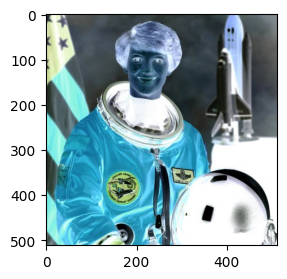

In [41]:
# RandomInvert - randomly inverts the colors of the given image
transform = v2.RandomInvert()
invert_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(invert_img.numpy(), (1, 2, 0)))
plt.show()

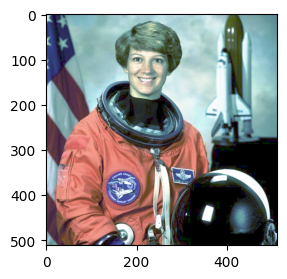

In [42]:
# RandomEqualize - randomly equalizes the histogram of the given image
transform = v2.RandomEqualize()
equalized_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(equalized_img.numpy(), (1, 2, 0)))
plt.show()

##### Randomly-applied Transforms

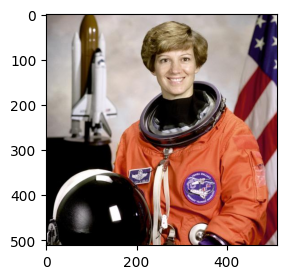

In [43]:
# RandomHorizontalFlip - performs horizontal flip of an image, with a given probability
transform = v2.RandomHorizontalFlip(p=0.5)
hflip_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(hflip_img.numpy(), (1, 2, 0)))
plt.show()

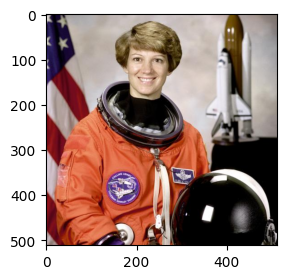

In [44]:
# RandomVerticalFlip - performs vertical flip of an image, with a given probability
transform = v2.RandomVerticalFlip(p=0.5)
vflip_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(vflip_img.numpy(), (1, 2, 0)))
plt.show()

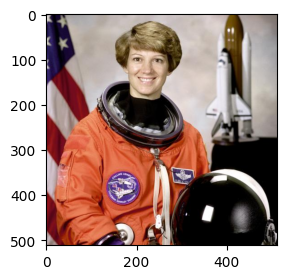

In [45]:
# RandomApply - transform randomly applies a list of transforms, with a given probability
transform = v2.RandomApply(transforms=[v2.RandomCrop(size=(64, 64)), ], p=0.5)
rand_crops_img = transform(img)

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(rand_crops_img.numpy(), (1, 2, 0)))
plt.show()

##### Torchvision Datasets and Dataloaders with Data Augmentation

In [46]:
torch.manual_seed(42)

# Transform
transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Download Dataset
cifar10_data = torchvision.datasets.CIFAR10('./Image/', transform=transforms, download=True)

# Create training dataset and validation dataset
train_split = 0.8
train_size = int(train_split * len(cifar10_data))
test_size = len(cifar10_data) - train_size
training_set, validation_set = torch.utils.data.random_split(cifar10_data, [train_size, test_size])

# Create dataloaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

print(cifar10_data.classes)

100%|██████████| 170M/170M [00:06<00:00, 27.5MB/s]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


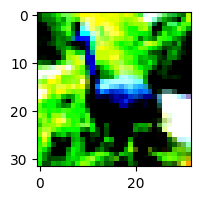

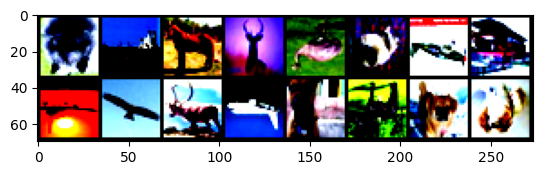

In [47]:
# Show dataset "bird" image
for img, label in cifar10_data:
    if label==cifar10_data.classes.index('bird'):
        image = img
        break
plt.figure(figsize=(2, 2))
plt.imshow(np.transpose(image.clamp(0, 1).numpy(), (1, 2, 0)))
plt.show()

# Show dataloader batch images
dataiter = iter(training_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(img_grid.clamp(0, 1).numpy(), (1, 2, 0)))
plt.show()